# Task 1

## Dataset

In [13]:
import pandas as pd 

labeled_df = pd.read_csv("labeled-data.csv")
unlabeled_df = pd.read_csv("unlabeled-data.csv")

Here we can see two dataframes. one is for labeled data and another one is for unlabeled data.

In [14]:
labeled_df

,review_text,review_score
0,"It&#146;s the best looking, most enticingly pu...",8
1,The Nintendo LABO Variety Kit has some fun and...,8
2,"But as far as sound investments go, buying up ...",8
3,"Starts out with a bang, but then quickly falls...",7
4,Valkyria Revolution tells a decent tale of war...,6
...,...,...
1245,The visuals will likely turn most off to what ...,8
1246,An unconventional city builder where the city ...,8
1247,The developer deserves props for doing somethi...,8
1248,"Not awful but far from good, Fate/Extella: The...",6


In [15]:
unlabeled_df

,review_text,review_score
0,While leaning heavily on traditional J-horror ...,NaN
1,Final Fantasy XIII-2 is a step in the right di...,NaN
2,"Ultimately, this is the type of title that wil...",NaN
3,Super Monkey Ball Banana Mania combines 300 st...,NaN
4,I was hoping that Mario Party 5 would be bette...,NaN
...,...,...
4995,The Metronomicon is a game for those who want ...,NaN
4996,Its surprisingly deep and satisfyingly weighty...,NaN
4997,Root Double: Before Crime * After Days is an e...,NaN
4998,NBA 2K23 is worth the price of admission almos...,NaN


Here we concatinate unlabeled and labeled data:

In [16]:
all_texts = pd.concat([labeled_df["review_text"], unlabeled_df["review_text"]], ignore_index=True)

In [17]:
import spacy
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


It is better to apply text lemmitization to have the simplest form of each word. Then, we remove stop words and puncuations to get a clear version of our text. 

In [18]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def spacy_preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]

    return ' '.join(tokens)

all_texts = all_texts.apply(spacy_preprocess)
labeled_df["review_text"] = labeled_df["review_text"].apply(spacy_preprocess)
unlabeled_df["review_text"] = unlabeled_df["review_text"].apply(spacy_preprocess)

## 1. Text Vectorization

### - Sentence Transformer 

In [19]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
labeled_embeddings_st = model.encode(labeled_df["review_text"].tolist(), show_progress_bar=True)
unlabeled_embeddings_st = model.encode(unlabeled_df["review_text"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

### - Word2Vec 

In [20]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tuf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tuf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [21]:
tokenized_texts = [word_tokenize(text) for text in all_texts]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)

In [22]:
import numpy as np
def get_sentence_embedding_w2v(tokens, model):
    valid_vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(valid_vectors, axis=0) if valid_vectors else np.zeros(model.vector_size)

In [23]:
labeled_embeddings_w2v = [get_sentence_embedding_w2v(word_tokenize(text), w2v_model) for text in labeled_df["review_text"]]
unlabeled_embeddings_w2v = [get_sentence_embedding_w2v(word_tokenize(text), w2v_model) for text in unlabeled_df["review_text"]]

### - Dimensionality Reduction and Visualization

#### <b>PCA</b> for W2V

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
labeled_pca_w2v = pca.fit_transform(labeled_embeddings_w2v)

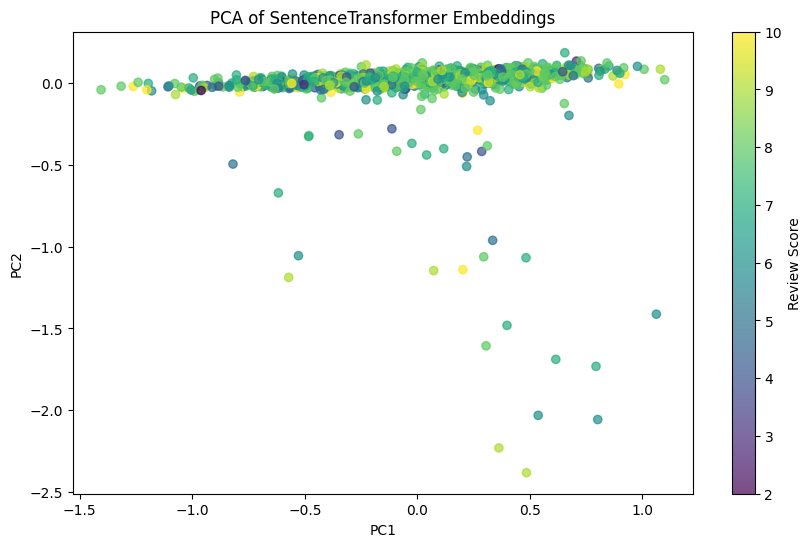

In [25]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
scatter = plt.scatter(labeled_pca_w2v[:, 0], labeled_pca_w2v[:, 1], c=labeled_df["review_score"], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Review Score')
plt.title("PCA of SentenceTransformer Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(False)
plt.show()

#### <b>PCA</b> for ST

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
labeled_pca_st = pca.fit_transform(labeled_embeddings_st)

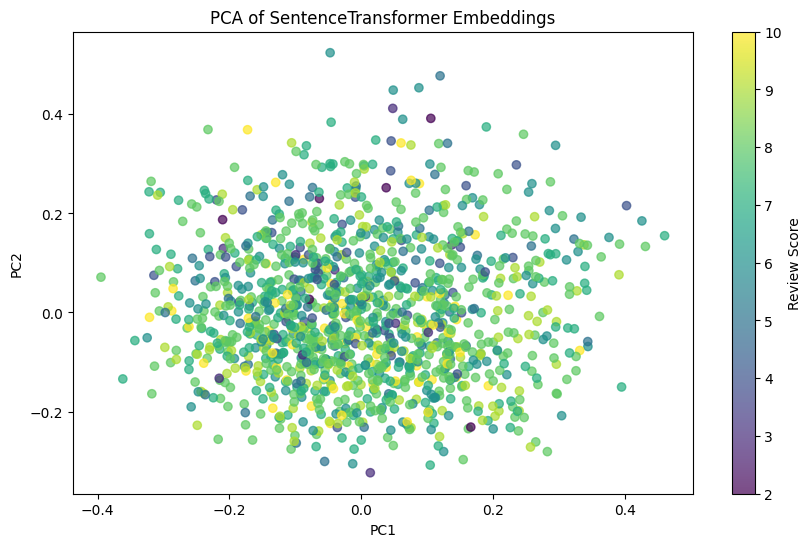

In [27]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
scatter = plt.scatter(labeled_pca_st[:, 0], labeled_pca_st[:, 1], c=labeled_df["review_score"], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Review Score')
plt.title("PCA of SentenceTransformer Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(False)
plt.show()

#### <b>T-SNE</b> for W2V

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
labeled_embeddings_w2v = np.array(labeled_embeddings_w2v)
tsne_results_w2v = tsne.fit_transform(labeled_embeddings_w2v)

c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


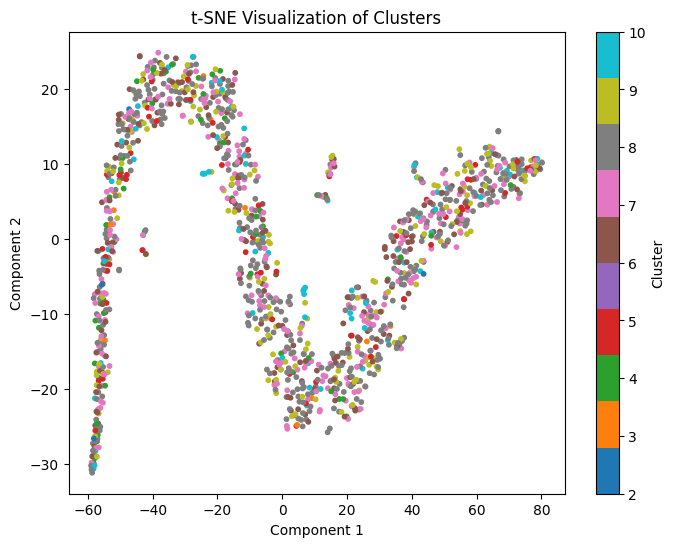

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_w2v[:, 0], tsne_results_w2v[:, 1], c=labeled_df["review_score"], cmap='tab10', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Cluster')
plt.grid(False)
plt.show()

#### <b>T-SNE</b> for ST

In [32]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
tsne_results_st = tsne.fit_transform(labeled_embeddings_st)

c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


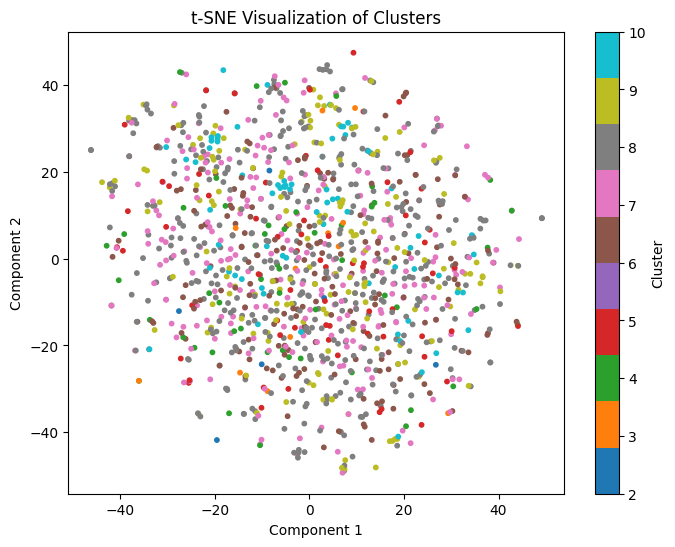

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_st[:, 0], tsne_results_st[:, 1], c=labeled_df["review_score"], cmap='tab10', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Cluster')
plt.grid(False)
plt.show()

<b>Why no clear pattern or clustering?</b> 

Review scores may be subjective and not directly tied to specific language features. Reviews with similar sentiment might have different scores (e.g., 6 vs 8).

## 2. Supervised Learning Baselines 

### Train & Test split:

In [34]:
from sklearn.model_selection import train_test_split

X = np.array(labeled_embeddings_st)
y = labeled_df['review_score'].values

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1111, random_state=42, stratify=y_trainval) 

### Classification Model

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

y_train = y_train - 2
y_val = y_val - 2
y_test = y_test - 2

At first, we need to find the best model among classifiers for this task. we measure the performance of each model based on metric for predicting validiation data:

In [36]:
def find_best_classifier_model(X_train, y_train, X_val, y_val):
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "RandomForest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    }

    best_model = None
    best_score = 0
    best_name = ""

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='macro')
        print(f"{name} F1 Macro: {f1:.4f}")
        if f1 > best_score:
            best_score = f1
            best_model = model
            best_name = name

    print(f"\nBest model: {best_name} with F1 Macro = {best_score:.4f}")
    return best_model, best_name

In [37]:
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(model_name, X_train, y_train):
    if model_name == "RandomForest":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
        }
        base_model = RandomForestClassifier(random_state=42)
    elif model_name == "LogisticRegression":
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'solver': ['liblinear', 'lbfgs']
        }
        base_model = LogisticRegression(max_iter=1000, random_state=42)
    elif model_name == "SVC":
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf']
        }
        base_model = SVC(probability=True, random_state=42)
    elif model_name == "XGBoost":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2]
        }
        base_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    else:
        raise ValueError("Unsupported model")

    grid_search = GridSearchCV(base_model, param_grid, scoring='f1_macro', cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [38]:
best_model, model_name = find_best_classifier_model(X_train, y_train, X_val, y_val)
from sklearn.metrics import classification_report

y_test_pred = best_model.predict(X_test)
print("\nFinal Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, digits=3))

LogisticRegression F1 Macro: 0.0776
SVC F1 Macro: 0.0592
RandomForest F1 Macro: 0.0648


c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:58:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 Macro: 0.1188

Best model: XGBoost with F1 Macro = 0.1188

Final Test Set Evaluation:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         5
           3      0.000     0.000     0.000         7
           4      0.200     0.105     0.138        19
           5      0.176     0.125     0.146        24
           6      0.367     0.733     0.489        45
           7      0.429     0.188     0.261        16
           8      0.000     0.000     0.000         7

    accuracy                          0.328       125
   macro avg      0.130     0.128     0.115       125
weighted avg      0.251     0.328     0.258       125



c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_clf, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_clf))

Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         5
           3      0.000     0.000     0.000         7
           4      0.000     0.000     0.000        19
           5      0.143     0.042     0.065        24
           6      0.362     0.933     0.522        45
           7      0.000     0.000     0.000        16
           8      0.000     0.000     0.000         7

    accuracy                          0.344       125
   macro avg      0.056     0.108     0.065       125
weighted avg      0.158     0.344     0.200       125

Confusion Matrix:
 [[ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  2  0  5  0  0]
 [ 0  0  0  0  0  1 18  0  0]
 [ 0  0  0  0  0  1 23  0  0]
 [ 0  0  0  0  0  3 42  0  0]
 [ 0  0  0  0  0  1 15  0  0]
 [ 0  0  0  

c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Regression Model

In [113]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report

def evaluate_regressors(X_train, y_train, X_test, y_test):
    regressors = {
        "RandomForest": RandomForestRegressor(random_state=42),
        "GradientBoosting": GradientBoostingRegressor(random_state=42),
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(random_state=42),
        "Lasso": Lasso(random_state=42),
        "SVR": SVR(),
        "KNN": KNeighborsRegressor()
    }
    
    results = {}
    best_model = None
    best_rmse = float("inf")
    
    for name, model in regressors.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_rounded = np.clip(np.round(y_pred), 1, 10).astype(int)
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            "model": model,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "y_pred": y_pred,
            "y_pred_rounded": y_pred_rounded
        }
        
        print(f"{name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = name
    
    print("\nBest model based on RMSE:", best_model)
    
    best = results[best_model]
    print(f"\nFinal chosen model: {best_model}")
    print(f"MAE: {best['MAE']:.3f}, RMSE: {best['RMSE']:.3f}, R2: {best['R2']:.3f}")
    print("Rounded Regression Classification Report:\n", classification_report(y_test, best["y_pred_rounded"], digits=3))
    
    return best["model"]

In [114]:
best_regressor = evaluate_regressors(X_train, y_train, X_test, y_test)

RandomForest -> MAE: 1.098, RMSE: 1.411, R2: 0.147
GradientBoosting -> MAE: 1.037, RMSE: 1.342, R2: 0.228
LinearRegression -> MAE: 1.405, RMSE: 1.669, R2: -0.194
Ridge -> MAE: 1.078, RMSE: 1.385, R2: 0.177
Lasso -> MAE: 1.209, RMSE: 1.527, R2: -0.000
SVR -> MAE: 0.998, RMSE: 1.315, R2: 0.258
KNN -> MAE: 1.118, RMSE: 1.455, R2: 0.093

Best model based on RMSE: SVR

Final chosen model: SVR
MAE: 0.998, RMSE: 1.315, R2: 0.258
Rounded Regression Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         5
           3      0.000     0.000     0.000         7
           4      0.667     0.316     0.429        19
           5      0.217     0.542     0.310        24
           6      0.453     0.533     0.490        45
           7      0.333     0.062     0.105        16
           8      0.000     0.000     0.000 

c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Comparison

In the above section, we can see the performance of the best regressor and also the best classifier. The best regressor which is SVM, has done better job than the best classifier. We can see it outperforms the classifier via the classification report matrix after rounding the results of regression. 

Regression is suitable for this task because if we consider this task as a classification task, there would be many classes (1 to 10). Due to number of different classes and lack of data, classifier can't learn the pattern of less populated class effectively. But the regressor model can learn the range of score numbers and predict it.

## 3. Semi-Supervised Learning (SSL) Strategies

In [115]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, roc_auc_score, roc_curve
import numpy as np

def evaluate_model(model, X_test, y_test, train_size):
    y_pred = model.predict(X_test)
    y_pred_rounded = np.clip(np.round(y_pred), 1, 10).astype(int)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred_rounded)
    f1 = f1_score(y_test, y_pred_rounded, average="macro")

    try:
        auc = roc_auc_score(y_test, y_pred, multi_class="ovr")
    except:
        auc = None

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Train_size": train_size,
        "R2": r2,
        "Accuracy": acc,
        "F1": f1,
        "AUC": auc,
        "y_pred": y_pred,
        "y_pred_rounded": y_pred_rounded
    }

### 3.1. Pseudo-Labeling 

In [116]:
best_regressor.fit(X_train, y_train)

SVR()

In [117]:
X_unlabeled = np.array(unlabeled_embeddings_st)
preds = best_regressor.predict(X_unlabeled)

In [ ]:
def pseudo_labeling(regressor, X_train, y_train, X_test, y_test, X_unlabeled, rounds=5, threshold=0.5):
    history = {"pseudo": []}
    X_train_curr, y_train_curr = X_train.copy(), y_train.copy()
    X_unlabeled_curr = X_unlabeled.copy()

    for r in range(rounds):
        regressor.fit(X_train_curr, y_train_curr)
        metrics = evaluate_model(regressor, X_test, y_test, len(X_train_curr))
        metrics["Round"] = r
        history["pseudo"].append(metrics)

        print(f"\n[Pseudo Round {r}]")
        print(f"Train size: {len(X_train_curr)} | Unlabeled size: {len(X_unlabeled_curr)}")
        print(f"MAE={metrics['MAE']:.3f}, RMSE={metrics['RMSE']:.3f}, "
              f"Acc={metrics['Accuracy']:.3f}, F1={metrics['F1']:.3f}, R2={metrics['R2']:.3f}, AUC={metrics['AUC']}")

        all_preds = np.stack([regressor.predict(X_unlabeled_curr) for regressor in regressor.estimators_], axis=1)
        stds = np.std(all_preds, axis=1)

        confident_idx = np.where(stds <= threshold)[0]
        if len(confident_idx) == 0:
            print("No confident samples found, stopping early.")
            break

        pseudo_X = X_unlabeled_curr[confident_idx]
        pseudo_y = np.clip(np.round(preds[confident_idx]), 1, 10).astype(int)

        X_train_curr = np.vstack([X_train_curr, pseudo_X])
        y_train_curr = np.concatenate([y_train_curr, pseudo_y])
        X_unlabeled_curr = np.delete(X_unlabeled_curr, confident_idx, axis=0)

        print(f"Added {len(confident_idx)} pseudo-labeled samples.")
        threshold = threshold * 0.98

    return history


In [168]:
regressor = RandomForestRegressor(random_state=42)
pseudo_labeling_history = pseudo_labeling(regressor, X_train, y_train, X_test, y_test, X_unlabeled, rounds=6, threshold = 1.05)


[Pseudo Round 0]
Train size: 1000 | Unlabeled size: 5000
MAE=1.098, RMSE=1.411, Acc=0.304, F1=0.098, R2=0.147, AUC=None
Added 27 pseudo-labeled samples.

[Pseudo Round 1]
Train size: 1027 | Unlabeled size: 4973
MAE=1.106, RMSE=1.417, Acc=0.272, F1=0.087, R2=0.140, AUC=None
Added 30 pseudo-labeled samples.

[Pseudo Round 2]
Train size: 1057 | Unlabeled size: 4943
MAE=1.108, RMSE=1.402, Acc=0.280, F1=0.088, R2=0.157, AUC=None
Added 21 pseudo-labeled samples.

[Pseudo Round 3]
Train size: 1078 | Unlabeled size: 4922
MAE=1.106, RMSE=1.406, Acc=0.288, F1=0.083, R2=0.152, AUC=None
Added 13 pseudo-labeled samples.

[Pseudo Round 4]
Train size: 1091 | Unlabeled size: 4909
MAE=1.104, RMSE=1.410, Acc=0.248, F1=0.073, R2=0.147, AUC=None
Added 18 pseudo-labeled samples.

[Pseudo Round 5]
Train size: 1109 | Unlabeled size: 4891
MAE=1.113, RMSE=1.420, Acc=0.288, F1=0.093, R2=0.136, AUC=None
Added 8 pseudo-labeled samples.


### 3.2. Active Learning 

In [121]:
def active_learning(regressor, X_train, y_train, X_test, y_test, X_unlabeled, unlabeled_texts, k=5, rounds=3):
    history = {"active": []}
    X_train_curr, y_train_curr = X_train.copy(), y_train.copy()
    X_unlabeled_curr = X_unlabeled.copy()
    texts_curr = list(unlabeled_texts)

    for r in range(rounds):
        regressor.fit(X_train_curr, y_train_curr)
        metrics = evaluate_model(regressor, X_test, y_test, len(X_train_curr))
        metrics["Round"] = r
        history["active"].append(metrics)

        print(f"\n[Active Round {r}]")
        print(f"Train size: {len(X_train_curr)} | Unlabeled size: {len(X_unlabeled_curr)}")
        print(f"MAE={metrics['MAE']:.3f}, RMSE={metrics['RMSE']:.3f}, "
              f"Acc={metrics['Accuracy']:.3f}, F1={metrics['F1']:.3f}, R2={metrics['R2']:.3f}, AUC={metrics['AUC']}")

        all_preds = np.stack([tree.predict(X_unlabeled_curr) for tree in regressor.estimators_], axis=1)
        stds = np.std(all_preds, axis=1)
        uncertain_idx = np.argsort(-stds)[:k]

        query_texts = [texts_curr[i] for i in uncertain_idx]
        df = pd.DataFrame({"review_text": query_texts, "score": [""]*len(query_texts)})
        fname = f"active_learning_round_{r+1}.csv"
        df.to_csv(fname, index=False)
        print(f"Exported {fname} — fill in the 'score' column for {len(query_texts)} samples.")
        input("Press Enter after labeling.")

        labeled = pd.read_csv(fname)
        new_X = X_unlabeled_curr[uncertain_idx]
        new_y = labeled["score"].astype(int).values

        X_train_curr = np.vstack([X_train_curr, new_X])
        y_train_curr = np.concatenate([y_train_curr, new_y])

        mask = np.ones(len(X_unlabeled_curr), dtype=bool)
        mask[uncertain_idx] = False
        X_unlabeled_curr = X_unlabeled_curr[mask]
        texts_curr = [t for i, t in enumerate(texts_curr) if mask[i]]

        print(f"Added {len(new_y)} actively labeled samples.")

    return history

In [132]:
active_history = active_learning(regressor, X_train, y_train, X_test, y_test, X_unlabeled, unlabeled_df["review_text"], k=10, rounds=10)


[Active Round 0]
Train size: 1000 | Unlabeled size: 5000
MAE=1.098, RMSE=1.411, Acc=0.304, F1=0.098, R2=0.147, AUC=None
Exported active_learning_round_1.csv — fill in the 'score' column for 10 samples.
Added 10 actively labeled samples.

[Active Round 1]
Train size: 1010 | Unlabeled size: 4990
MAE=1.089, RMSE=1.407, Acc=0.272, F1=0.088, R2=0.151, AUC=None
Exported active_learning_round_2.csv — fill in the 'score' column for 10 samples.
Added 10 actively labeled samples.

[Active Round 2]
Train size: 1020 | Unlabeled size: 4980
MAE=1.097, RMSE=1.400, Acc=0.264, F1=0.086, R2=0.160, AUC=None
Exported active_learning_round_3.csv — fill in the 'score' column for 10 samples.
Added 10 actively labeled samples.

[Active Round 3]
Train size: 1030 | Unlabeled size: 4970
MAE=1.046, RMSE=1.360, Acc=0.320, F1=0.110, R2=0.207, AUC=None
Exported active_learning_round_4.csv — fill in the 'score' column for 10 samples.
Added 10 actively labeled samples.

[Active Round 4]
Train size: 1040 | Unlabeled s

## 4. Comparative Performance Analysis 

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(histories):
    for key, vals in histories.items():
        rounds = [m["Round"] for m in vals]
        maes = [m["MAE"] for m in vals]
        rmse = [m["RMSE"] for m in vals]
        plt.plot(rounds, maes, marker="o", label=f"{key} MAE")
        plt.plot(rounds, rmse, marker="x", label=f"{key} RMSE")
    plt.xlabel("Rounds")
    plt.ylabel("Metric")
    plt.legend()
    plt.show()

def plot_roc_curves(histories, y_test):
    for key, vals in histories.items():
        for m in vals:
            fpr, tpr, _ = roc_curve(y_test, m["y_pred"], pos_label=10) 
            plt.plot(fpr, tpr, label=f"{key} Round {m['Round']} AUC={m['AUC']:.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

In [137]:
def plot_learning_curve(history_pseudo, history_active, metric="F1"):
    pseudo_list = history_pseudo['pseudo']
    active_list = history_active['active']

    pseudo_samples = [h['Train_size'] for h in pseudo_list]
    active_samples = [h['Train_size'] for h in active_list]

    pseudo_metric = [h[metric] for h in pseudo_list]
    active_metric = [h[metric] for h in active_list]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.plot(pseudo_samples, pseudo_metric, marker='o', label="Pseudo-Labeling")
    plt.plot(active_samples, active_metric, marker='s', label="Active Learning")
    plt.xlabel("Number of Labeled Samples")
    plt.ylabel(metric)
    plt.title(f"Learning Curve ({metric})")
    plt.legend()
    plt.grid(False)
    plt.show()


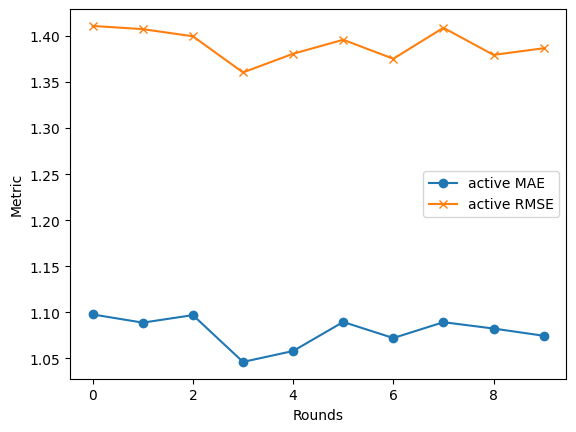

In [169]:
plot_learning_curves(active_history)

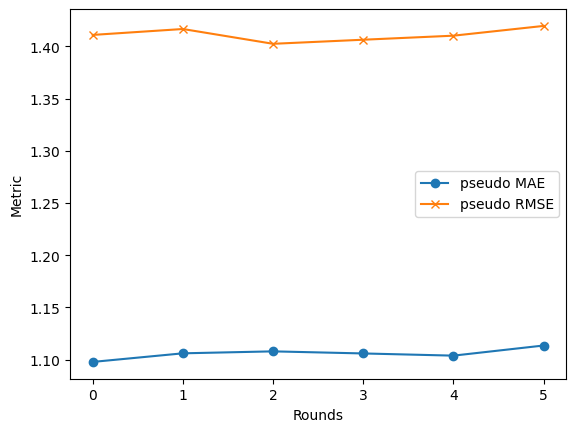

In [170]:
plot_learning_curves(pseudo_labeling_history)

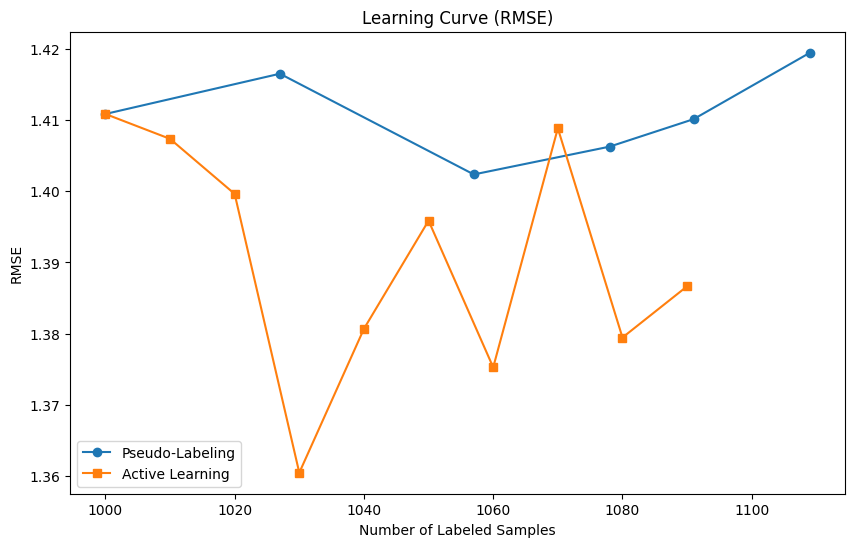

In [171]:
plot_learning_curve(pseudo_labeling_history, active_history, metric="RMSE")

In our experiments, both Pseudo-Labeling (PL) and Active Learning (AL) improved model performance, but in different ways. PL allowed us to quickly expand the training set by adding high-confidence predictions from the unlabeled data; however, performance sometimes degraded when incorrect pseudo-labels were included, demonstrating the risk of confirmation bias. AL, on the other hand, focused on the most uncertain samples and used expert labeling, leading to steady and reliable improvement in metrics while requiring fewer samples. For our video game score prediction task, AL proved more effective due to the high-quality, informative labels it added, whereas PL was useful for low-risk confident samples. Overall, a combined approach—starting with PL and refining with AL—can combine the strengths of both semi-supervised learning starategies.